# Домашнее задание по теме “Подбор параметров сети”
## Выполнила: Китова Екатерина Денисовна, 324 группа

### Постановка задачи:
2*) Наша задача заключается в доработке нейронной сети из предоставленного ноутбука perceptron(цветочек) для предотвращения переобучения путем добавления L2-регуляризации в функцию потерь

Основные цели:
1) реализовать регуляризацию с параметром lmdb;
2) модифицировать обратный ход распространения ошибки;
3) провести анализ изменений и оценить их влияние на результат.




---



## Изначальная программа

In [1]:
import numpy as np

# Функция активации нейрона в выходном слое и ее производная
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def dsigmoid(y):
    return y * (1 - y)

# Функция активации нейронов во внутреннем слое и ее производная
def tanh(x):
    return np.tanh(x)
def dtanh(y):
    return 1 - y * y

In [2]:
from matplotlib import pyplot as plt

class Perceptron:
    def __init__(self, X, Y, hidden_size):

        # Пусть n - количество признаков, m - количество объектов, k - размерность результирующего вектора
        # Тогда X = X(n * m), Y = Y(k, m)
        assert X.shape[1] == Y.shape[1]
        self.X = X
        self.Y = Y
        self.m = X.shape[1]

        # Инициализируем матрицы весов рандомными числами (W1 - для скрытого слоя, W2 - для выходного, в нем всего 1 нейрон)
        self.W1 = np.random.randn(hidden_size, X.shape[0])
        self.W2 = np.random.randn(Y.shape[0], hidden_size)

        # Заполняем свободные векторы нулями
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((Y.shape[0], 1))

        # Здесь будем накапливать значения функции потерь на каждой итерации
        self.ce_loss = []
        self.mse_loss = []

    def learn(self, iter_num, learning_rate):

        # Итерируемся необходимое количество раз
        for i in range(iter_num):

            # Расчет взыешенных сумм каждого из нейронов, применение функций активации
            # Для того, чтобы заменить функции активации, необходимо заменить функцию при вычислении А1/А2
            Z1 = np.dot(self.W1, self.X) + self.b1                                     # (hidden_size, X.shape[1])
            A1 = tanh(Z1)
            Z2 = np.dot(self.W2, A1) + self.b2                                         # (Y.shape[0], X.shape[1] = Y.shape[1])
            A2 = sigmoid(Z2)

            # Среднеквадратичная (MSE) функция потерь
            mse_loss = np.sum((A2 - self.Y) ** 2) / self.m

            # Cross entropy функция потерь
            eps = 1e-8
            logprobs = self.Y * np.log(A2 + eps) + (1 - self.Y) * np.log(1 - A2 + eps)
            ce_loss = (-1 / self.m) * np.sum(logprobs)

            # Запоминание значения функции потерь и печать на каждой 1000-й итерации
            self.mse_loss.append(mse_loss)
            self.ce_loss.append(ce_loss)
            if i % 1000 == 0: print(f"MSE loss: {mse_loss}, CE loss: {ce_loss}")

            # Алгоритм обратного распространения ошибки
            # Производные высчитываются по правилу производной для сложной функции
            # Оптимизируется среднеквадратичная функция потерь
            # Для оптимизации cross entropy необходимо заменить производную функции потерь по A2 - self.Y
            # Для этого необходимо найти dError/dW
            # При замене функций активации необходимо также заменить соответствующую ей производную
            dA2 = (A2 - self.Y) * dsigmoid(A2)        # dLoss/dA * dSig/dZ2            # (Y.shape[0], Y.shape[1] = X.shape[1])
            dW2 = np.dot(dA2, A1.T)                   # dZ2/dW2                        # (Y.shape[0], hidden_size)
            db2 = np.sum(dA2, axis=1, keepdims=True)                                   # (Y.shape[0], 1)
            dA1 = np.dot(self.W2.T, dA2) * dtanh(A1)  # dA2 * dZ2/dA1 * dTanh/dZ       # (hidden_size, Y.shape[1] = X.shape[1])
            dW1 = np.dot(dA1, self.X.T)               # dZ1/dW                         # (hidden_size, X.shape[0])
            db1 = np.sum(dA1, axis=1, keepdims=True)                                   # (hidden_size, 1)

            # Обновление весов методом градиентного спуска
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1

    def predict(self, X):
        # Используем найденные матрицы весов
        A1 = tanh(np.dot(self.W1, X) + self.b1)
        A2 = sigmoid(np.dot(self.W2, A1) + self.b2)
        return (A2[0] > 0.5).astype(int)

    def plot(self):
        plt.figure(figsize=(10,3))
        plt.subplot(1, 2, 1)
        plt.ylabel('MSE loss')
        plt.xlabel('Iterations')
        plt.plot(self.mse_loss)
        plt.subplot(1, 2, 2)
        plt.ylabel('CE loss')
        plt.xlabel('Iterations')
        plt.plot(self.ce_loss)

### Разделение цветочка

In [3]:
# Создать датасет в виде цветочка, m - кол-во объектов (целое больше 1), a - максимальная длина листа (float больше 0)
def create_flower(m, a):
    D = 2
    N = int(m/2)
    X = np.zeros((m,D))
    Y = np.zeros((m,1), dtype='uint8')
    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2
        r = a*np.sin(4*t) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
    return X.T, Y.T

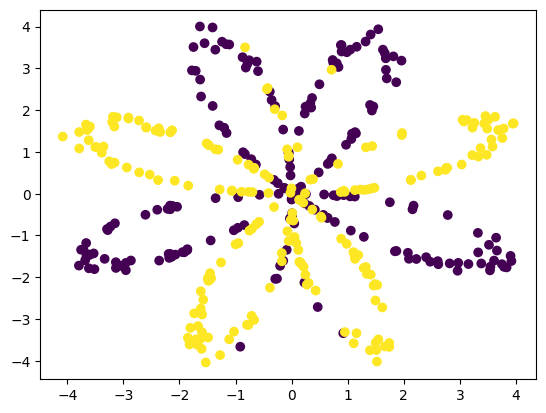

In [4]:
# Создаем и рисуем датасет в форме цветочка с 1000 объектов, цветами обозначены метки классов
X, Y = create_flower(400, 4)
plt.scatter(X[0, :], X[1, :], c=Y);

In [5]:
# Строим разделяющую  прямую, показывающую результат обучения нейросети
def plot_division(perceptron):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral);

### Один нейрон

In [6]:
perceptron = Perceptron(X, Y, 1)
perceptron.learn(10000, 0.1)

MSE loss: 0.25050513546653386, CE loss: 0.6941599989798283
MSE loss: 0.21717170451656664, CE loss: 0.6260749968043807
MSE loss: 0.21659957558890086, CE loss: 0.624880810573511
MSE loss: 0.2162264180806957, CE loss: 0.6241139944191071
MSE loss: 0.21592665397647198, CE loss: 0.6234981100365239
MSE loss: 0.2156736485639532, CE loss: 0.6229759077882465
MSE loss: 0.2154563828453444, CE loss: 0.6225252881081774
MSE loss: 0.21526778844776984, CE loss: 0.6221325139312741
MSE loss: 0.21510255349489313, CE loss: 0.62178723889628
MSE loss: 0.21495652224674308, CE loss: 0.6214812786234599


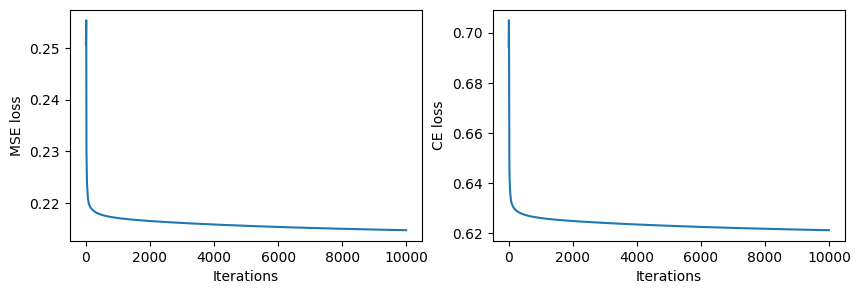

In [7]:
perceptron.plot()

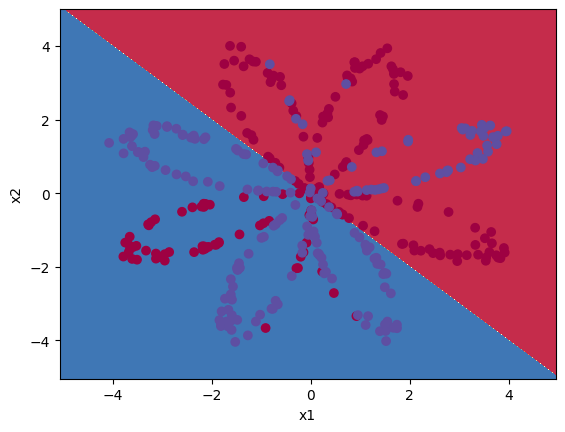

In [8]:
# Строим разделяющую  прямую, показывающую результат обучения нейросети
plot_division(perceptron)

### Четыре нейрона

In [9]:
perceptron = Perceptron(X, Y, 4)
perceptron.learn(10000, 0.1)

MSE loss: 0.2689181805553808, CE loss: 0.7414773762833176
MSE loss: 0.066442856272152, CE loss: 0.22420377771519143
MSE loss: 0.06256129673218339, CE loss: 0.21550822949129303
MSE loss: 0.060566360006856855, CE loss: 0.22123023500892675
MSE loss: 0.05913599471428793, CE loss: 0.2298671141983479
MSE loss: 0.06166654199507846, CE loss: 0.26386495272491384
MSE loss: 0.05824461183650427, CE loss: 0.23915983677569558
MSE loss: 0.0597631730639775, CE loss: 0.23924853776133734
MSE loss: 0.058760723433661025, CE loss: 0.25117871064289016
MSE loss: 0.058234346146024796, CE loss: 0.2505577516686605


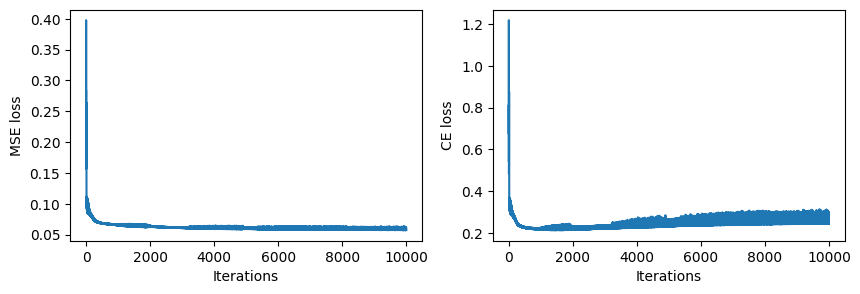

In [10]:
perceptron.plot()

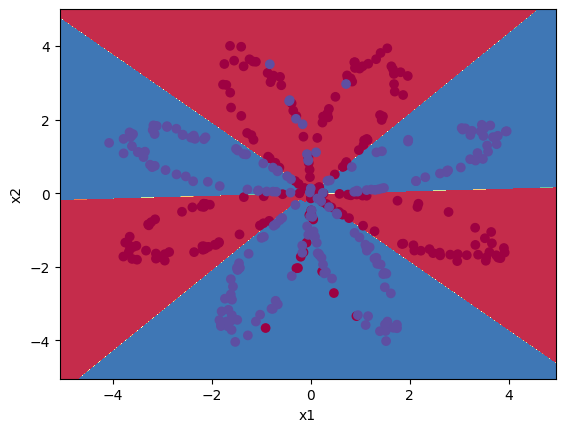

In [11]:
plot_division(perceptron)

### много нейронов - стало ли лучше?

In [12]:
perceptron = Perceptron(X, Y, 40)
perceptron.learn(10000, 0.1)

MSE loss: 0.2723211765173663, CE loss: 0.8445331532506296
MSE loss: 0.06555340265703719, CE loss: 0.3146961237093764
MSE loss: 0.056826984908541614, CE loss: 0.3799034285167718
MSE loss: 0.042934092514758965, CE loss: 0.28537326435126814
MSE loss: 0.04375369628633065, CE loss: 0.30116537198982923
MSE loss: 0.038373973134128214, CE loss: 0.2753505365153002
MSE loss: 0.039890862423000835, CE loss: 0.2662341560154578
MSE loss: 0.039111599482025354, CE loss: 0.2729017405467793
MSE loss: 0.03923434242407893, CE loss: 0.27717624555580905
MSE loss: 0.033837304926269456, CE loss: 0.2526993101024727


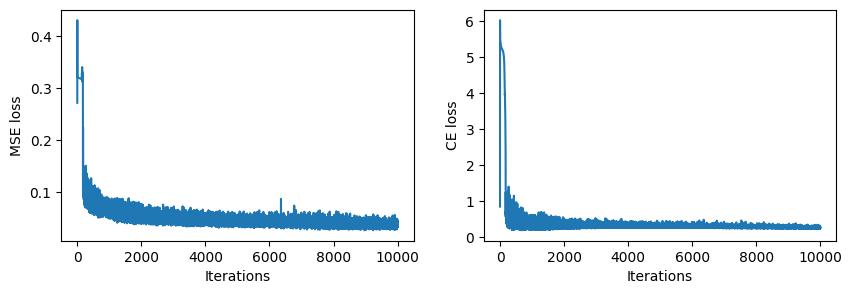

In [13]:
perceptron.plot()

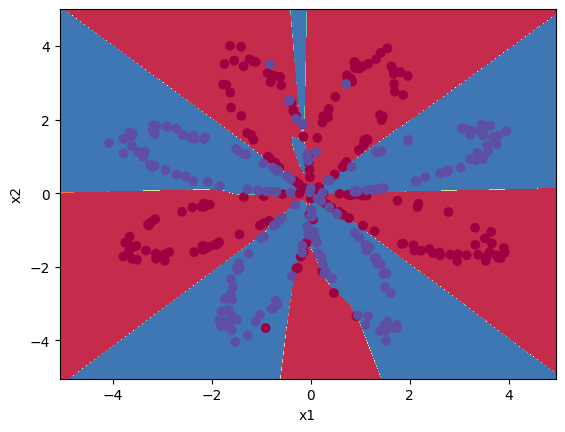

In [14]:
plot_division(perceptron)

## Решение




### Входные данные:
Представляют собой набор двумерных точек, которые нужно разбить на 2 класса для бинарной классификации



### Подбор обучающей выборки:
Выборка заранее размечена для бинарной классификации (2 класса, представленных цветами). Для обучения использовалось 200 точек:

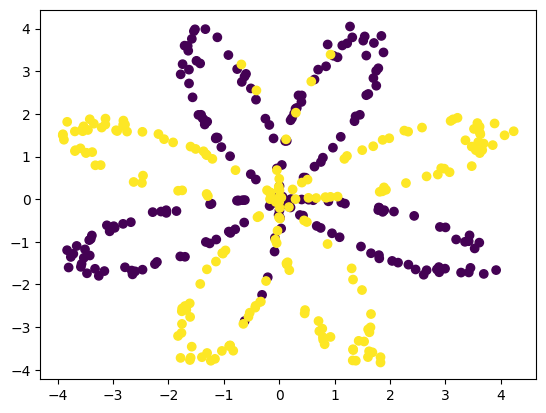

In [15]:
# Создаем и рисуем датасет в форме цветочка с 1000 объектов, цветами обозначены метки классов
X, Y = create_flower(400, 4)
plt.scatter(X[0, :], X[1, :], c=Y);

### Выбор архитектуры сети
Количество входных нейронов фиксировано и равно 2, т.к. модель работает
с точками в двумерном пространстве; на выходе у нас 1 нейрон, поскольку
у нас задача бинарной классификации. Значение на выходе понимается как
вероятность принадлежности к одному из двух классов.

Количество нейронов в скрытом слое варьируется от случая, которых у нас
3:
1) 1 нейрон в скрытом слое. В этом случае модель может различать
только линейно разделимые данные и точки разделяются одной
прямой (что недостаточно для сложных границ разделения)
2) 4 нейрона в скрытом слое. Такой подход позволяет представлять
более сложные границы разделения за счет нелинейности. Это
подходящая архитектура для небольшой задачи, так как модель
становится достаточно гибкой
3) 40 нейронов в скрытом слое. В данном случае модель становится
избыточно сложной для текущей задачи, и границы разделения
становятся чересчур адаптированными к обучающим данным, что
приводит к переобучению.
Для решения проблемы переобучения будем использовать параметр
регуляризации λ
Отметим, что у нас полносвязная архитектура, то есть каждый нейрон
предыдущего слоя соединен с каждым нейроном следующего слоя

### Функция активации:
1) для скрытого слоя используется гиперболический тангенс (tanh)
2) для выходного слоя используется сигмоидная функция (sigmoid)

In [16]:
# Функция активации нейрона в выходном слое и ее производная
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def dsigmoid(y):
    return y * (1 - y)

# Функция активации нейронов во внутреннем слое и ее производная
def tanh(x):
    return np.tanh(x)
def dtanh(y):
    return 1 - y * y

### Метод обучения
В исходной версии инициализация весов выполнялась с использованием
малых случайных значений. Градиентный спуск использовался для
обновления весов, включая обратное распространение ошибки.
Так, для решения нашей задачи мы добавили регуляризация в функцию
потерь и вычисление градиентов.

Функция потерь:

```
# Функция потерь (MSE с регуляризацией)
mse_loss = (np.sum((A2 - self.Y) ** 2) + (lmdb / (2 * self.m)) * (np.sum(self.W1**2) + np.sum(self.W2**2))) / self.m
self.mse_loss.append(mse_loss)
```

Обратное распространение ошибки:

```
# Обратное распространение
dA2 = (A2 - self.Y) * A2 * (1 - A2)
dW2 = np.dot(dA2, A1.T) + (lmdb / self.m) * self.W2
db2 = np.sum(dA2, axis=1, keepdims=True)
dA1 = np.dot(self.W2.T, dA2) * (1 - A1**2)
dW1 = np.dot(dA1, self.X.T) + (lmdb / self.m) * self.W1
db1 = np.sum(dA1, axis=1, keepdims=True)
```



> Все эти изменения будут ниже в исправленом коде







###Методы проверки правильности:
1) оценка качества по значению функций потерь
2) визуализация границ разделения на графике

###Оценка правильности решения:
Ранее модели с 1, 4 и 40 нейронами демонстрировали разные результаты:

*1 нейрон:*

In [17]:
perceptron = Perceptron(X, Y, 1)
perceptron.learn(10000, 0.1)

MSE loss: 0.24970157336337861, CE loss: 0.6925502963672812
MSE loss: 0.22032212851227592, CE loss: 0.6326658985610023
MSE loss: 0.2196820826407984, CE loss: 0.6313241756455402
MSE loss: 0.2193311989935647, CE loss: 0.6305851723354567
MSE loss: 0.2190979817995109, CE loss: 0.6300930165747743
MSE loss: 0.2189269446367178, CE loss: 0.6297319062724896
MSE loss: 0.2187934667324753, CE loss: 0.6294501853242617
MSE loss: 0.2186847155931927, CE loss: 0.6292208269311983
MSE loss: 0.21859326996065925, CE loss: 0.6290281580006137
MSE loss: 0.218514506331741, CE loss: 0.6288623943957756


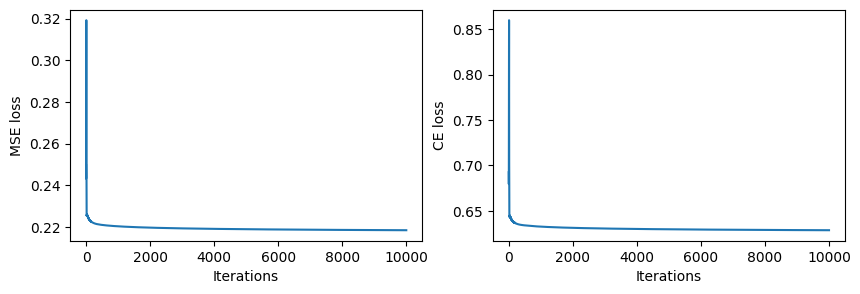

In [18]:
perceptron.plot()

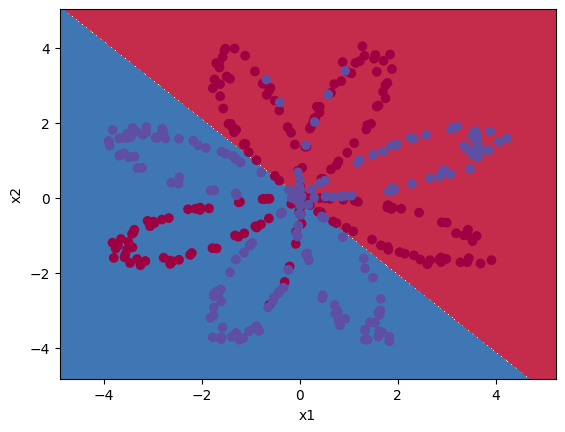

In [19]:
plot_division(perceptron)

Как мы видим, 1 нейрона недостаточно для решения задачи

*4 нейрона:*



In [20]:
perceptron = Perceptron(X, Y, 4)
perceptron.learn(10000, 0.1)

MSE loss: 0.2359331317536498, CE loss: 0.6632422414875282
MSE loss: 0.05974850148988395, CE loss: 0.20535596926348032
MSE loss: 0.05578282155191177, CE loss: 0.19487707531257922
MSE loss: 0.05308644664558744, CE loss: 0.18782846923525698
MSE loss: 0.05579150346063288, CE loss: 0.19474777293273135
MSE loss: 0.05306764860253356, CE loss: 0.18629901158807013
MSE loss: 0.05273185070434491, CE loss: 0.18544720896612435
MSE loss: 0.05249300486602085, CE loss: 0.18509176965021215
MSE loss: 0.05231068646740576, CE loss: 0.1850836043790686
MSE loss: 0.05216661358425852, CE loss: 0.1853144551377594


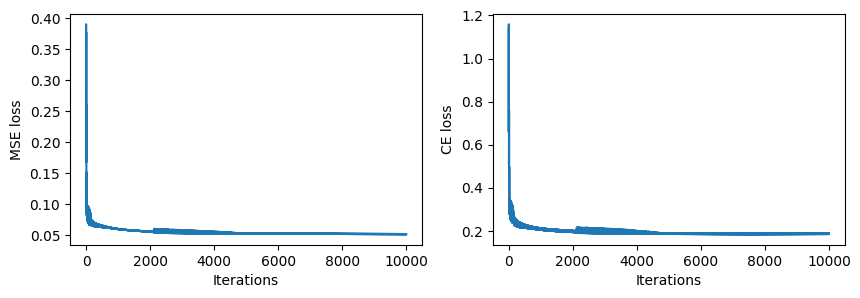

In [21]:
perceptron.plot()

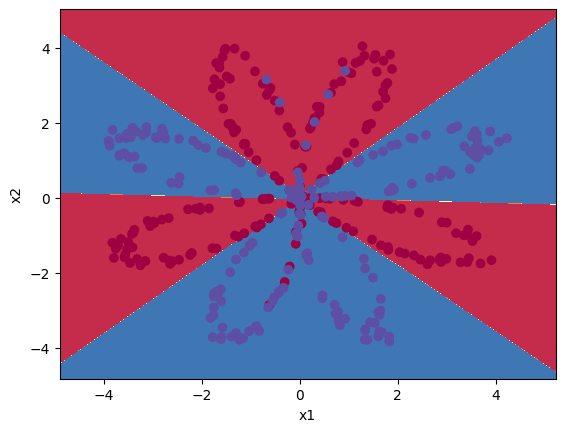

In [22]:
plot_division(perceptron)

Так, при 4 нейронах наша нейросеть правильно классифицирует абсолютное большинство данных по обучающей выборке

*40 нейронов:*

In [23]:
perceptron = Perceptron(X, Y, 40)
perceptron.learn(10000, 0.1)

MSE loss: 0.44111845926945975, CE loss: 3.759789954188309
MSE loss: 0.05183967541825437, CE loss: 0.3630938268735872
MSE loss: 0.04882003476799365, CE loss: 0.4369952566590385
MSE loss: 0.04588462948853084, CE loss: 0.4402762910545711
MSE loss: 0.044931738397384506, CE loss: 0.4388008643116397
MSE loss: 0.047938222657432174, CE loss: 0.441943430384667
MSE loss: 0.04345826109878872, CE loss: 0.4464250522401792
MSE loss: 0.04202985822565457, CE loss: 0.45040710152232466
MSE loss: 0.04551150062593535, CE loss: 0.47738899374692845
MSE loss: 0.037171414911130005, CE loss: 0.47290949154330314


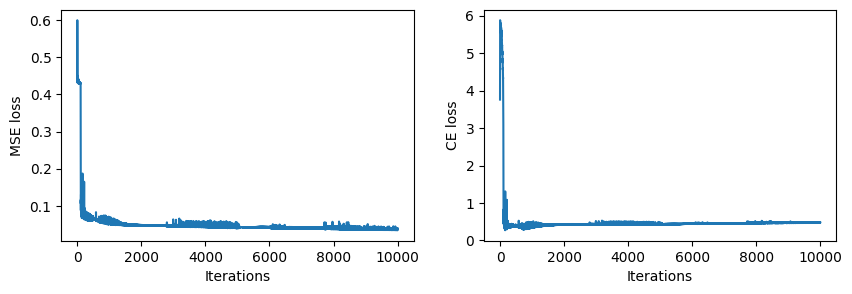

In [24]:
perceptron.plot()

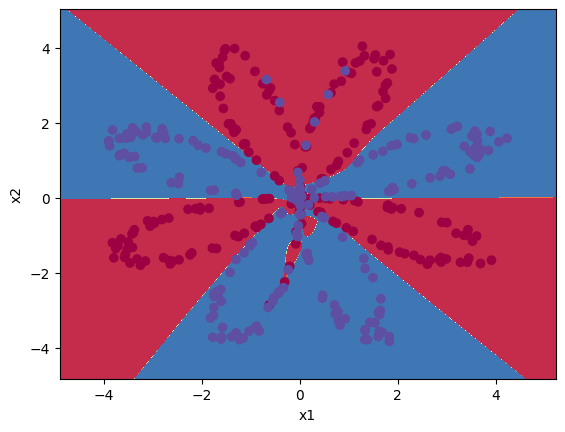

In [25]:
plot_division(perceptron)

Как видно из графика, при 40 нейронах наблюдается переобучение

### Изменения:
После модификации будем рассматривать лишь случай с 40 нейронами,
так как граница разделения при 1 нейроне всегда является прямой и не
решает исходной задачи, а при 4 нейронах наша задача уже хорошо
выполняется. Также для удобства будем строить единый график потерь для
MSE Loss и CE Loss.
Как можно будет увидеть позже, регуляризация позволяет улучшить
поведение сети и сделать границу разделения более плавной и правильной,
при этом значение функции потерь CE Loss стало ближе к 0

Ниже представлен измененный код c указанными выше правками:

In [26]:
import numpy as np

# Функция активации нейрона в выходном слое и ее производная
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def dsigmoid(y):
    return y * (1 - y)

# Функция активации нейронов во внутреннем слое и ее производная
def tanh(x):
    return np.tanh(x)
def dtanh(y):
    return 1 - y * y

In [27]:
from matplotlib import pyplot as plt

class Perceptron:
    def __init__(self, X, Y, hidden_size):

        # Пусть n - количество признаков, m - количество объектов, k - размерность результирующего вектора
        # Тогда X = X(n * m), Y = Y(k, m)
        assert X.shape[1] == Y.shape[1]
        self.X = X
        self.Y = Y
        self.m = X.shape[1]

        # Инициализируем матрицы весов рандомными числами (W1 - для скрытого слоя, W2 - для выходного, в нем всего 1 нейрон)
        self.W1 = np.random.randn(hidden_size, X.shape[0])
        self.W2 = np.random.randn(Y.shape[0], hidden_size)

        # Заполняем свободные векторы нулями
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((Y.shape[0], 1))

        # Здесь будем накапливать значения функции потерь на каждой итерации
        self.ce_loss = []
        self.mse_loss = []

    def learn(self, epochs, learning_rate, lmdb): # добавили параметр lmbd

        # Итерируемся необходимое количество раз
        for i in range(epochs):

            # Прямое распространение
            Z1 = np.dot(self.W1, self.X) + self.b1
            A1 = tanh(Z1)
            Z2 = np.dot(self.W2, A1) + self.b2
            A2 = sigmoid(Z2)

            # Функция потерь (MSE с регуляризацией)
            mse_loss = (np.sum((A2 - self.Y) ** 2) + (lmdb / (2 * self.m)) * (np.sum(self.W1**2) + np.sum(self.W2**2))) / self.m
            self.mse_loss.append(mse_loss)

            # Функция потерь (CE)
            epsilon = 1e-12  # защита от логарифма нуля
            A2_clipped = np.clip(A2, epsilon, 1 - epsilon)
            ce_loss = -np.sum(self.Y * np.log(A2_clipped) + (1 - self.Y) * np.log(1 - A2_clipped)) / self.m
            self.ce_loss.append(ce_loss)

            if i % 1000 == 0:
                print(f"Epoch {i}: MSE loss = {mse_loss}, CE loss = {ce_loss}")

            # Обратное распространение
            dA2 = (A2 - self.Y) * A2 * (1 - A2)
            dW2 = np.dot(dA2, A1.T) + (lmdb / self.m) * self.W2
            db2 = np.sum(dA2, axis=1, keepdims=True)
            dA1 = np.dot(self.W2.T, dA2) * (1 - A1**2)
            dW1 = np.dot(dA1, self.X.T) + (lmdb / self.m) * self.W1
            db1 = np.sum(dA1, axis=1, keepdims=True)

            # Обновление параметров
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1

        # Отображение графиков
        self.plot()

    def plot(self):
        """Визуализация графиков функции потерь"""
        plt.plot(self.mse_loss, label="MSE Loss")
        plt.plot(self.ce_loss, label="CE Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.legend()
        plt.show()

    def predict(self, X):
        # используем найденные матрицы весов
        A1 = tanh(np.dot(self.W1, X) + self.b1)
        A2 = sigmoid(np.dot(self.W2, A1) + self.b2)
        return (A2[0] > 0.5).astype(int)

In [28]:
# Создать датасет в виде цветочка, m - кол-во объектов (целое больше 1), a - максимальная длина листа (float больше 0)
def create_flower(m, a):
    D = 2
    N = int(m/2)
    X = np.zeros((m,D))
    Y = np.zeros((m,1), dtype='uint8')
    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2
        r = a*np.sin(4*t) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
    return X.T, Y.T

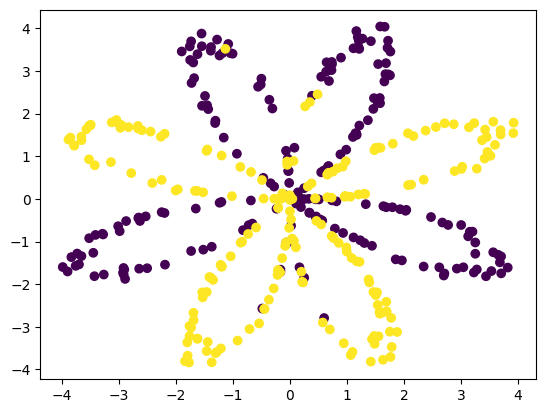

In [29]:
# Создаем и рисуем датасет в форме цветочка с 1000 объектами, цветами обозначены метки классов
X, Y = create_flower(400, 4)
plt.scatter(X[0, :], X[1, :], c=Y);

In [30]:
# Строим разделяющую  прямую, показывающую результат обучения нейросети
def plot_division(perceptron):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral);

### Рекомендации по выбору λ:
Чересчур малые значения λ подходят для небольших архитектур (1 или 4
нейрона), где переобучение очень незначительно.
Средние значения λ (около 0.01) оптимальны для сложных архитектур (в
нашем случае 40 нейронов), обеспечивая баланс между точностью и
обобщением. Поведение модели при таком параметре приведено ниже.
Большие λ обычно используются для случаев, когда модель имеет слишком
много параметров, но они могут привести к недообучению.


Так, рассмотрим поведение нашей модели при λ = 0.01. Для правильной
работы модели следует соответствующим образом подобрать
гиперпараметры, так как в противном случае модель переобучится лишь
сильнее:

Epoch 0: MSE loss = 0.6037623784215779, CE loss = 3.4548709588870077
Epoch 1000: MSE loss = 0.05008658784568465, CE loss = 0.16700769457370832
Epoch 2000: MSE loss = 0.04317185055133695, CE loss = 0.14378584272822134
Epoch 3000: MSE loss = 0.039961617820776424, CE loss = 0.13255724899909324
Epoch 4000: MSE loss = 0.03801881864544461, CE loss = 0.12514369526615915
Epoch 5000: MSE loss = 0.03660758322778099, CE loss = 0.11971829960546984
Epoch 6000: MSE loss = 0.035458305220052944, CE loss = 0.11552002802302361
Epoch 7000: MSE loss = 0.03443762106257439, CE loss = 0.11208504649813436
Epoch 8000: MSE loss = 0.033496509396929074, CE loss = 0.10910668090974396
Epoch 9000: MSE loss = 0.032622360775102874, CE loss = 0.1064137084853666


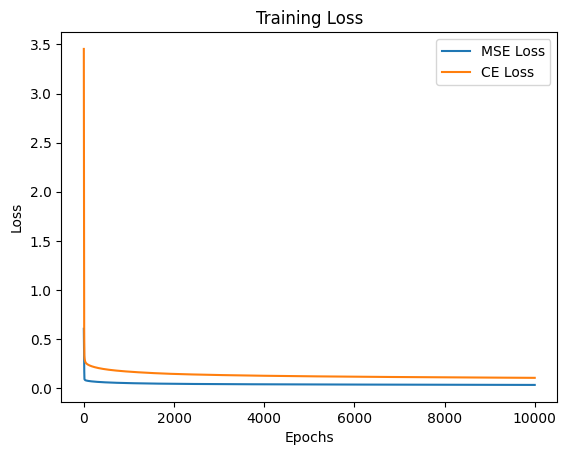

In [31]:
# Создаём объект класса Perceptron
perceptron = Perceptron(X, Y, 40)

# Вызываем метод learn с параметром регуляризации
perceptron.learn(epochs=10000, learning_rate=0.01, lmdb=0.01)

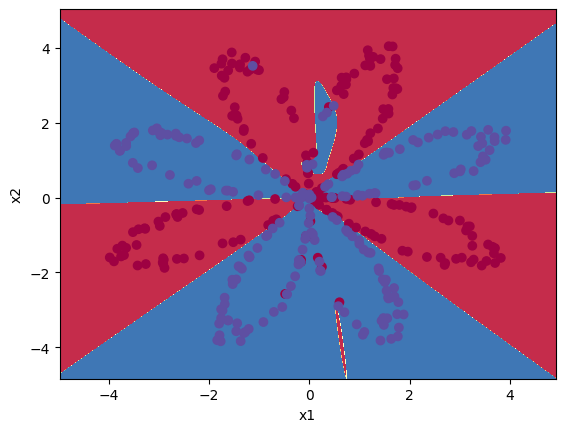

In [32]:
plot_division(perceptron)

Заметим что график функций потерь падает катастрофически быстро, и модель
чересчур сильно подстраивается под обучающие данные. Попробуем
изменить гиперпараметры следующим образом:

Epoch 0: MSE loss = 0.5812940621714343, CE loss = 2.548614686810546
Epoch 1000: MSE loss = 0.11266016628829555, CE loss = 0.37217124825077436
Epoch 2000: MSE loss = 0.09296787154887383, CE loss = 0.3248138362508483
Epoch 3000: MSE loss = 0.08936606289574492, CE loss = 0.3129932188062839
Epoch 4000: MSE loss = 0.08728632551649135, CE loss = 0.30533801198994015
Epoch 5000: MSE loss = 0.08572319782948566, CE loss = 0.2991035541092272
Epoch 6000: MSE loss = 0.0844469294913141, CE loss = 0.293622454003428
Epoch 7000: MSE loss = 0.08335815183602166, CE loss = 0.2886044980712227
Epoch 8000: MSE loss = 0.08239801861930643, CE loss = 0.283886736335001
Epoch 9000: MSE loss = 0.08152663428141536, CE loss = 0.27937347777168425
Epoch 10000: MSE loss = 0.08071512893167322, CE loss = 0.2750156719491133
Epoch 11000: MSE loss = 0.07994221022093631, CE loss = 0.27080244562033134
Epoch 12000: MSE loss = 0.0791928935368878, CE loss = 0.2667558162755556
Epoch 13000: MSE loss = 0.07845841487787932, CE loss 

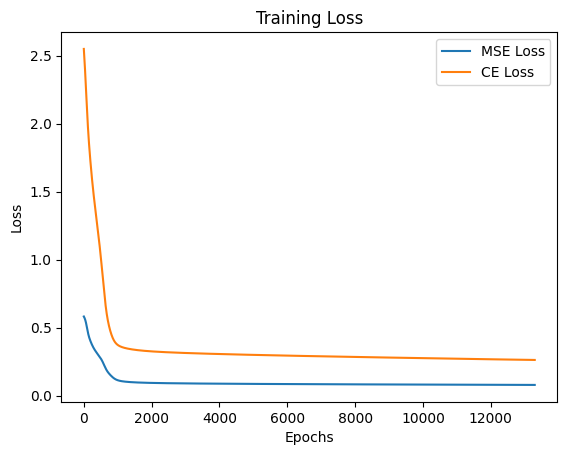

In [41]:
# Создаём объект класса Perceptron
perceptron = Perceptron(X, Y, 40)

# Вызываем метод learn с параметром регуляризации
perceptron.learn(epochs=13300, learning_rate=0.00004, lmdb=0.01)

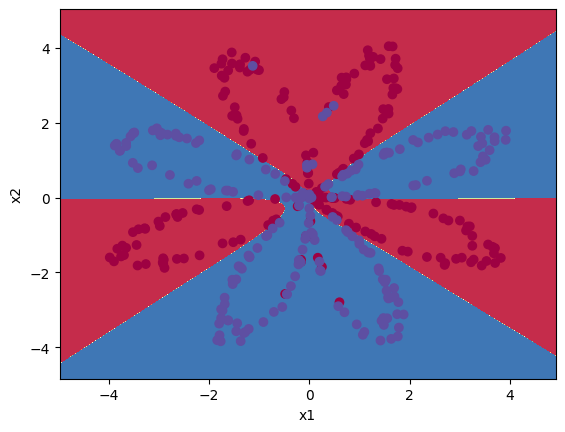

In [42]:
plot_division(perceptron)

Теперь модель работает аналогично тому , как работала при 4 нейронах.
Попробуем уменьшить скорость обучения, увеличив соответственно число
эпох, при этом убавив параметр регуляризации, например, до 0.001 и сохранив
результат обучения нейросети:

Epoch 0: MSE loss = 0.3774373370222317, CE loss = 1.8033665583354224
Epoch 1000: MSE loss = 0.28257208522004035, CE loss = 1.3210946911414578
Epoch 2000: MSE loss = 0.1890431681176732, CE loss = 0.574518120549972
Epoch 3000: MSE loss = 0.1067538640051779, CE loss = 0.3852248487925698
Epoch 4000: MSE loss = 0.09736234380266351, CE loss = 0.3597787326045278
Epoch 5000: MSE loss = 0.09320661284831173, CE loss = 0.34725760243893616
Epoch 6000: MSE loss = 0.09063628056192323, CE loss = 0.33904462527043727
Epoch 7000: MSE loss = 0.08880155908553507, CE loss = 0.3329254319369707
Epoch 8000: MSE loss = 0.08738700344139995, CE loss = 0.3280270153828603
Epoch 9000: MSE loss = 0.0862431857236296, CE loss = 0.32392048704904314
Epoch 10000: MSE loss = 0.08528784637413045, CE loss = 0.3203633102121329
Epoch 11000: MSE loss = 0.08447087380443984, CE loss = 0.3172038740275684
Epoch 12000: MSE loss = 0.08375944587313718, CE loss = 0.31433991211703083
Epoch 13000: MSE loss = 0.08313086383538026, CE loss

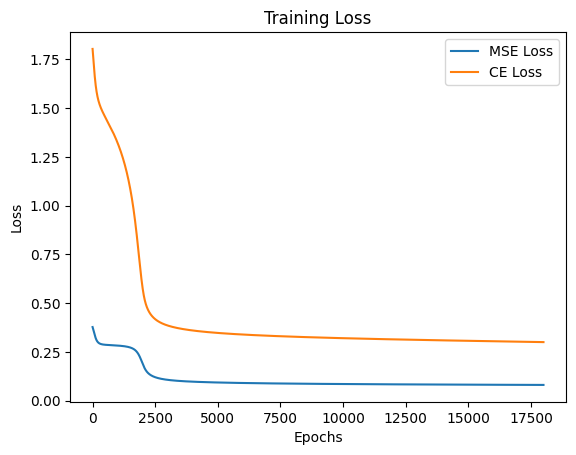

In [49]:
# Создаём объект класса Perceptron
perceptron = Perceptron(X, Y, 40)

# Вызываем метод learn с параметром регуляризации
perceptron.learn(epochs=18000, learning_rate=0.00003, lmdb=0.001)

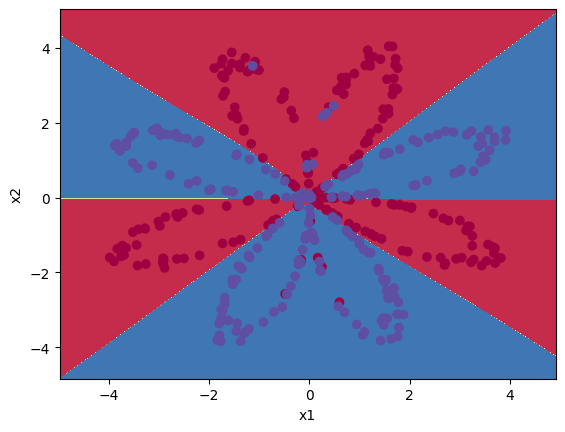

In [50]:
plot_division(perceptron)

Такая настройка объясняется тем, что меньшая регуляризация требует
более точной настройки модели, то есть меньшей скорости обучения,
большего числа эпох

Попробуем увеличить параметр регуляризации до 0.1, сохранив результат:

Epoch 0: MSE loss = 0.3575795013185805, CE loss = 0.9657615650995578
Epoch 1000: MSE loss = 0.09505070035985712, CE loss = 0.3184283941196712
Epoch 2000: MSE loss = 0.0893245770184055, CE loss = 0.2974444412629056
Epoch 3000: MSE loss = 0.08615879176691235, CE loss = 0.2854309901632889
Epoch 4000: MSE loss = 0.08390246136996522, CE loss = 0.2769229564525118
Epoch 5000: MSE loss = 0.08213027188613381, CE loss = 0.2703031801307312
Epoch 6000: MSE loss = 0.08066096682803064, CE loss = 0.2648539108411468
Epoch 7000: MSE loss = 0.07940242389896145, CE loss = 0.2602101125260184
Epoch 8000: MSE loss = 0.07830196494098975, CE loss = 0.2561659661406911
Epoch 9000: MSE loss = 0.07732587724223226, CE loss = 0.25259262872955834


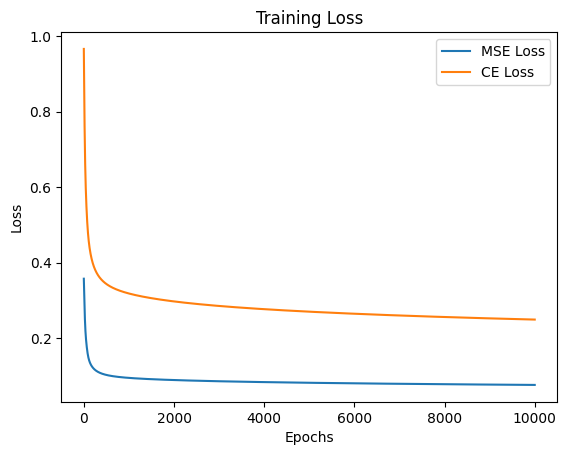

In [51]:
# Создаём объект класса Perceptron
perceptron = Perceptron(X, Y, 40)

# Вызываем метод learn с параметром регуляризации
perceptron.learn(epochs=10000, learning_rate=0.00006, lmdb=0.1)

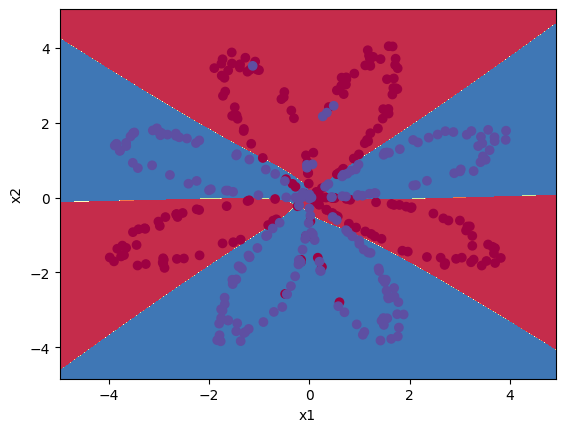

In [52]:
plot_division(perceptron)

В данном случае количество эпох — 10000, шаг обучения — 0.00006. Так,
более высокая регуляризация предотвращает переобучение даже при
большем шаге обучения и меньшем числе эпох.

### Итоги:
Основные цели поставленной задачи были выполнены:
1) реализована регуляризация с параметром lmdb
2) модифицирован обратный ход распространения ошибки
3) проведен анализ изменений и оценка их влияния на результат

Так, для всех трех комбинаций гиперпараметры обеспечивают достаточно гладкую траекторию сходимости функции потерь (MSE и CE), что указывает на корректный баланс между шагом обновления весов и штрафом за величину весов, при этом сохраняя корректную результативность нашей модели